In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [2]:
print('x')

x


In [3]:
def save_dataset(X, dataset_type, N, F, sample_num, seed,extra_meta_info=None,dataset_sub_type=None,extra_param_info = None):
    
    """
    code to save synthetic datasets in a uniform-ish file hierarchy and update a corresponding metadata file with parameter info
    """


    # check if subfolder name passed or needed
    if dataset_sub_type is not None:
        folder = f"../synthetic_data/{dataset_type}/{dataset_sub_type}"
    else:
        folder = f"../synthetic_data/{dataset_type}/"
        
    os.makedirs(folder, exist_ok=True)

    # save the point cloud
    fname = f"sample{sample_num}_seed{seed}.npy"
    path = os.path.join(folder, fname)
    np.save(path, X)

    # metadata row construct
    meta_path = os.path.join(folder, "meta.csv")
    row_given = {
        "filename": fname,
        "N": N,
        "F": F,
        "sample_num": sample_num,
        "seed": seed
    }

    # save any groundtruth labels given
    if extra_param_info is not None:
        
        param_folder = os.path.join(folder,'parameter_info/')
        os.makedirs(param_folder, exist_ok=True)

        for kv in extra_param_info.keys():

            fname_y = f"{kv}_sample{sample_num}_seed{seed}.npy"
            path_y = os.path.join(param_folder ,fname_y)

            np.save(path_y, extra_param_info[kv])
            
            row_given[f'{kv}_filename'] = fname_y

    # add extra metadata info specific to the data gen mechanism to the csv
    if extra_meta_info is not None:        
        row = {**row_given, **extra_meta_info}
    else:
        row = row_given

    # save params in meta
    if os.path.exists(meta_path):
        df = pd.read_csv(meta_path)
        df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)
    else:
        df = pd.DataFrame([row])

    df.to_csv(meta_path, index=False)

    return fname

In [4]:
# generate a list of random seeds to use for saving data

rng = np.random.default_rng(42)
num_seeds = 10

random_seeds_lst = rng.integers(0, 2**20, size=num_seeds).tolist()

In [5]:
from sklearn import datasets

## plotting helpers

In [6]:
def scatter_helper(ax, xs, ys, zs=None, class_label = None):

    """
    plot a 2d or 3d scatter plot and color using given class labels if any
    """

    if zs is not None:
        if class_label is not None:
            sc = ax.scatter(xs, ys, zs, c=class_label, cmap='tab10', s=10)
        else:
            sc = ax.scatter(xs, ys, zs, s=10)
        return sc

    else:
        if class_label is not None:
            sc = ax.scatter(xs, ys, c=class_label, cmap='tab10', s=10)
        else:
            sc = ax.scatter(xs, ys, s=10)
        return sc
    
    return None

def plot_3d_scatters(X,title_name,y=None,custom_inx=[0,1,2]):

    """
    plot 4 subplots: 1st is a 3d scatter plot, the other 3 show 2d / pairwise marginals
    """

    fig, axs = plt.subplots(1, 4, figsize=(15, 3), subplot_kw={})

    axs[0] = fig.add_subplot(1, 4, 1, projection='3d')
    xs,ys,zs = X[:, custom_inx[0]], X[:, custom_inx[1]], X[:, custom_inx[2]]
    scatter_helper(axs[0],xs,ys,zs,y)
    axs[0].set_title(title_name)

    # 2D scatter plots
    scatter_helper(axs[1],xs,ys,None,y)
    axs[1].set_title(f'{custom_inx[0]} vs {custom_inx[1]}')

    scatter_helper(axs[2],ys,zs,None,y)
    axs[2].set_title(f'{custom_inx[1]} vs {custom_inx[2]}')

    scatter_helper(axs[3],xs,zs,None,y)
    axs[3].set_title(f'{custom_inx[0]} vs {custom_inx[2]}')
        
    # plt.xlim(-2.5, 2.5)
    # plt.ylim(-2.5, 2.5)

    plt.tight_layout()
    plt.show()


## save gaussian homoskedastic blobs

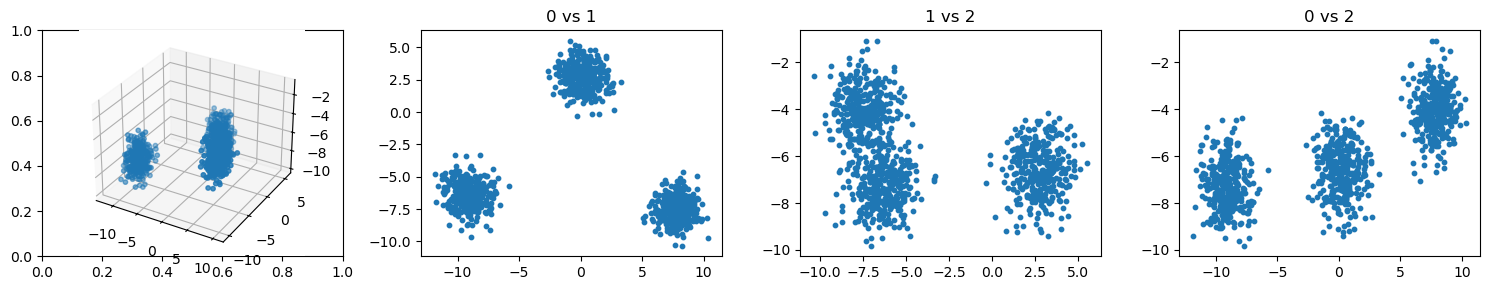

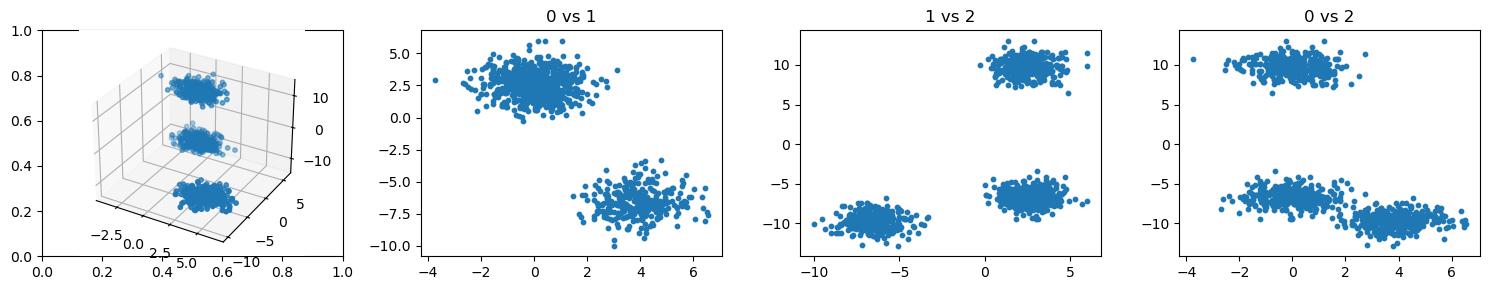

In [7]:
dataset_type = 'gaussian_homoskedastic_blobs'
n_samples = 1000
n_features = 3

for n_features in [3,10]:

    for n_centers in [3]:
        for cluster_std in [1.0]:

            dataset_subtype = f'N{n_samples}_P{n_features}/k{n_centers}_std{cluster_std}'

            for sample_num,seed in enumerate(random_seeds_lst):

                X, y = datasets.make_blobs(n_samples=n_samples,n_features=n_features, random_state=seed, centers=n_centers,cluster_std=cluster_std)
                extra_meta_info = {'cluster_std' : cluster_std}

                extra_param_info = {'cluster_label' : y}

                save_dataset(X, dataset_type, n_samples, n_features, 
                            sample_num, seed,dataset_sub_type=dataset_subtype,
                            extra_meta_info=extra_meta_info,
                            extra_param_info=extra_param_info)

                if sample_num == 0:
                    plot_3d_scatters(X,'',y=None)


## save gaussian heteroskedastic blobs

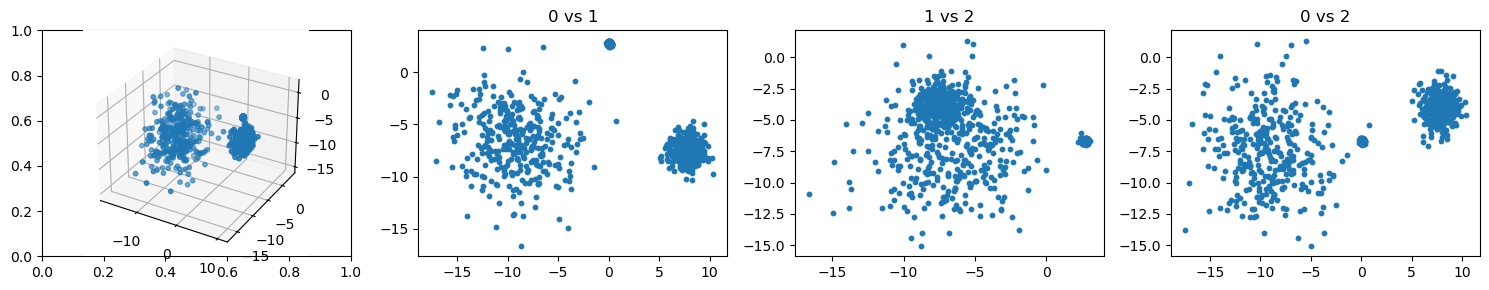

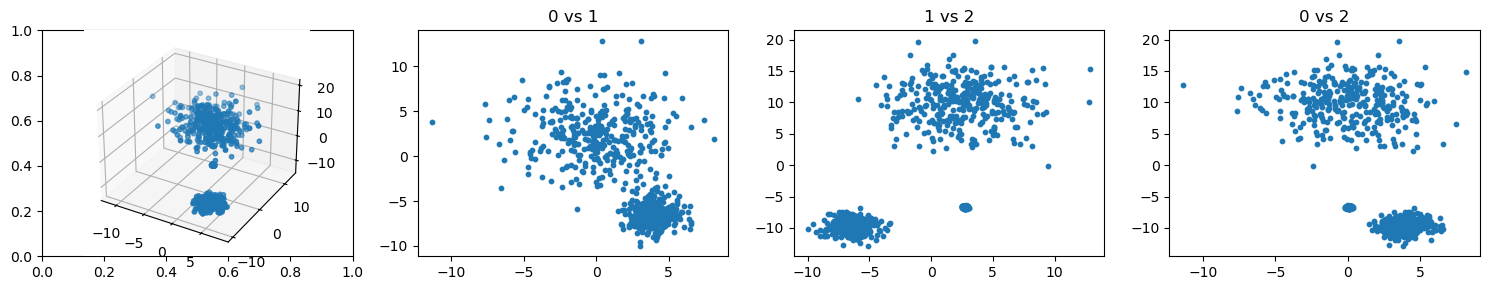

In [8]:
dataset_type = 'gaussian_heteroskedastic_blobs'
n_samples = 1000
# n_features = 3

cluster_std = [0.1,1.0,3.0]
n_centers = 3
heterosk_ver = 0

# cluster_std = [0.1,1.0,3.0,2.0,10.0]
# n_centers = 5
# heterosk_ver = 1

for n_features in [3,10]:

    dataset_subtype = f'N{n_samples}_P{n_features}/k{n_centers}_std_v{heterosk_ver}'

    for sample_num,seed in enumerate(random_seeds_lst):
        
        X, y = datasets.make_blobs(n_samples=n_samples,n_features=n_features, random_state=seed, centers=n_centers,cluster_std=cluster_std)

        extra_param_info = {'cluster_label' : y, 'cluster_std' : cluster_std}

        save_dataset(X, dataset_type, n_samples, n_features, sample_num, seed,
                    extra_param_info=extra_param_info,dataset_sub_type=dataset_subtype)
        
        if sample_num == 0:
            plot_3d_scatters(X,'',y=None)


## save noisy torus

In [9]:
def noisy_torus(n_samples=1000, R=2, r=1, noise=None, random_state=None, center=(0, 0, 0)):
    """    
    """
    rng = np.random.default_rng(random_state)
    
    # sample angles u, v uniformly
    u = rng.uniform(0, 2 * np.pi, n_samples)
    v = rng.uniform(0, 2 * np.pi, n_samples)
    
    # parametric eqn for torus
    x = (R + r * np.cos(v)) * np.cos(u)
    y = (R + r * np.cos(v)) * np.sin(u)
    z = r * np.sin(v)
    
    # additive gaussian noise to each point that can vary/stretch by feature
    if noise is not None:
        assert len(noise)==3

        x += rng.normal(0, noise[0], n_samples)
        y += rng.normal(0, noise[1], n_samples)
        z += rng.normal(0, noise[2], n_samples)
    
    return np.stack([x, y, z], axis=1)


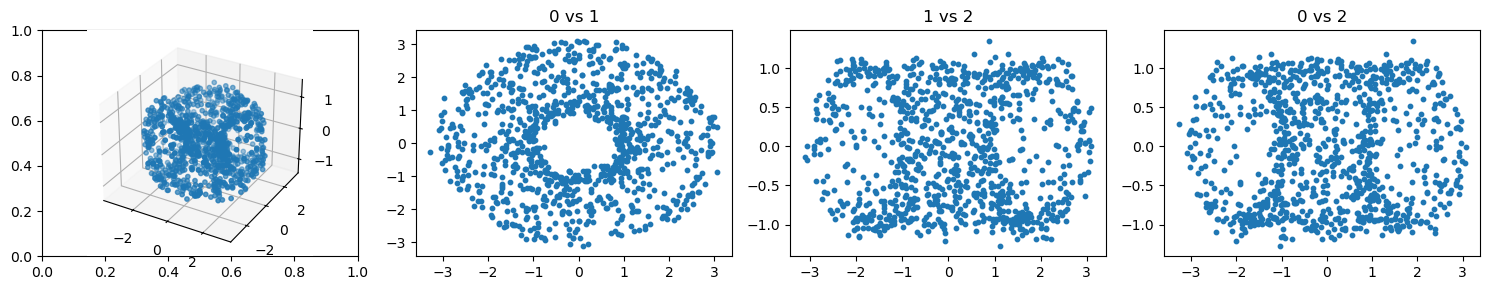

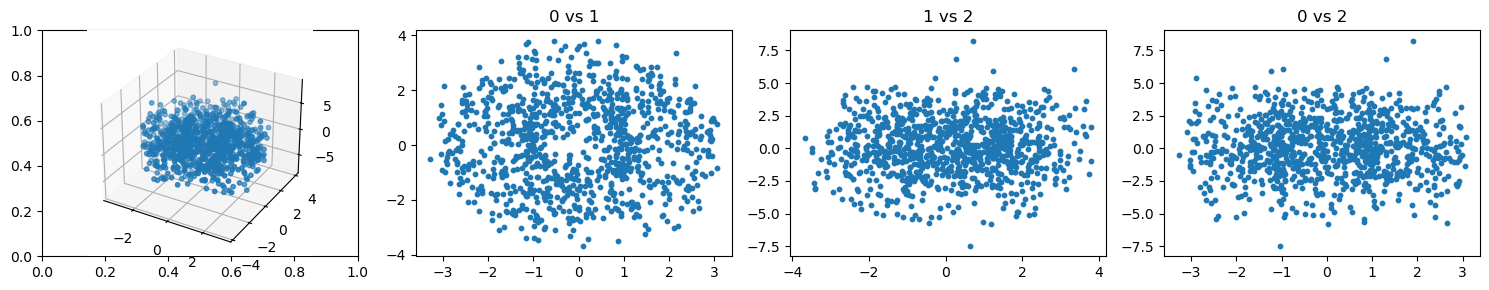

In [10]:
dataset_type = 'noisy_torus'
n_samples = 1000
n_features = 3

noise_ver_vec_dict = {'v0' : [0.1,0.1,0.1], 'v1' : [0.1,0.5,2.0]}

for noise_ver in noise_ver_vec_dict.keys():

    noise_vec = noise_ver_vec_dict[noise_ver]

    dataset_subtype = f'N{n_samples}_P{n_features}/noise_{noise_ver}'

    for sample_num,seed in enumerate(random_seeds_lst):

        X = noisy_torus(n_samples=n_samples,noise=noise_vec,random_state=seed)

        extra_param_info = {'noise' : noise_vec}

        save_dataset(X, dataset_type, n_samples, n_features, sample_num, seed,
                     extra_param_info=extra_param_info,dataset_sub_type=dataset_subtype)

        if sample_num == 0:
            plot_3d_scatters(X,'',y=None)


## save elliptical homoskedastic blobs

In [11]:
def make_heteroskedastic_anisotropic_blobs_nd(
    n_samples=1000, n_features=3, cluster_std=1.0, 
    transforms=None, random_state=None,centers=1):

    """    
    """
    
    if isinstance(cluster_std, float):
        # num_center = 1
        pass
    elif isinstance(cluster_std, list):
        assert centers == len(cluster_std)
    else:
        # raise error
        return

    # generate gaussian blobs first
    X, y = datasets.make_blobs(
        n_samples=n_samples,
        n_features=n_features,
        cluster_std=cluster_std,
        random_state=random_state,
        centers=centers
    )

    # create a random transform to stretch these blobs in diff ways and make them anisotropic
    # right now -> doing it label wise / per cluster but can also do a global transform
    unique_labels = np.unique(y)
    rng = np.random.default_rng(random_state)

    if transforms is None:
        transforms = {
            label: rng.normal(size=(n_features, n_features))*3.0
            for label in unique_labels
        }

    X_transformed = np.zeros_like(X)

    for label in unique_labels:
        T = transforms[label]
        X_transformed[y == label] = X[y == label] @ T.T

    return X_transformed, y, transforms


In [12]:
# ellips_homosk_clusters[2]

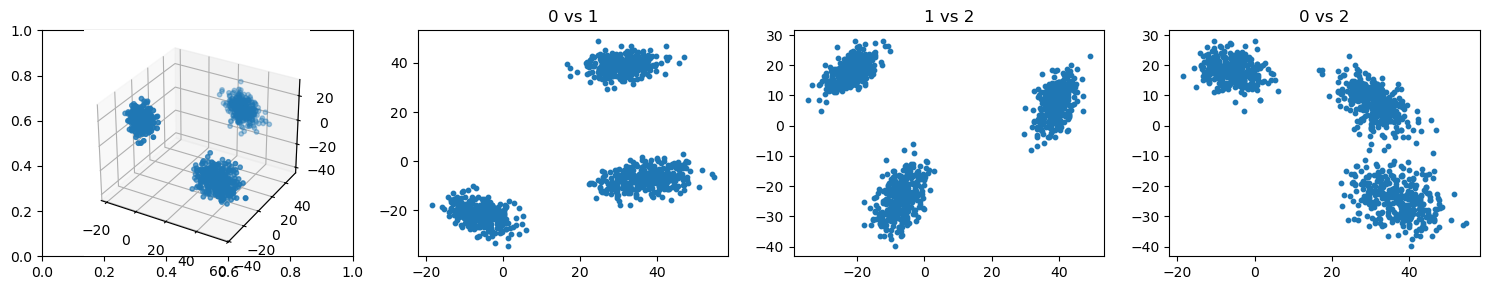

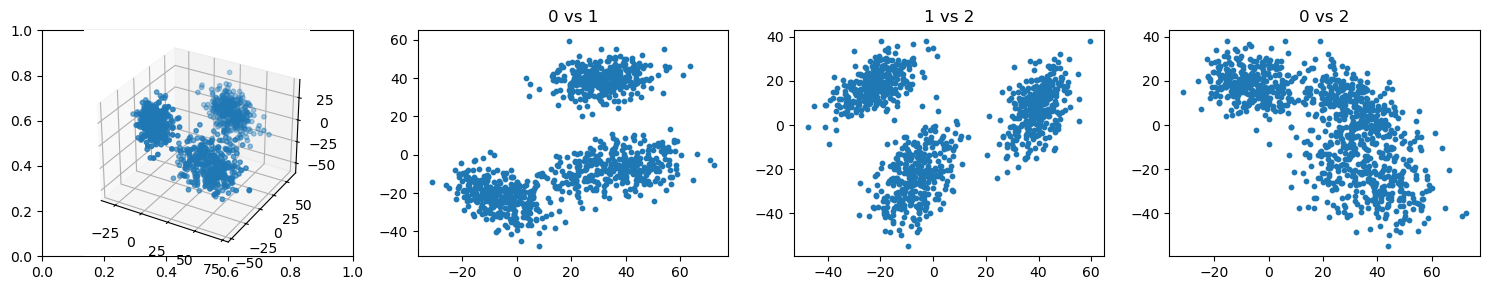

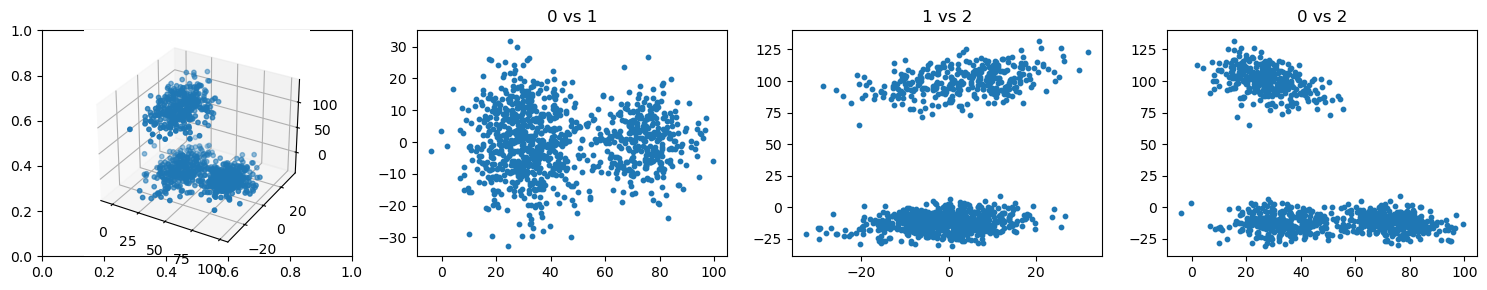

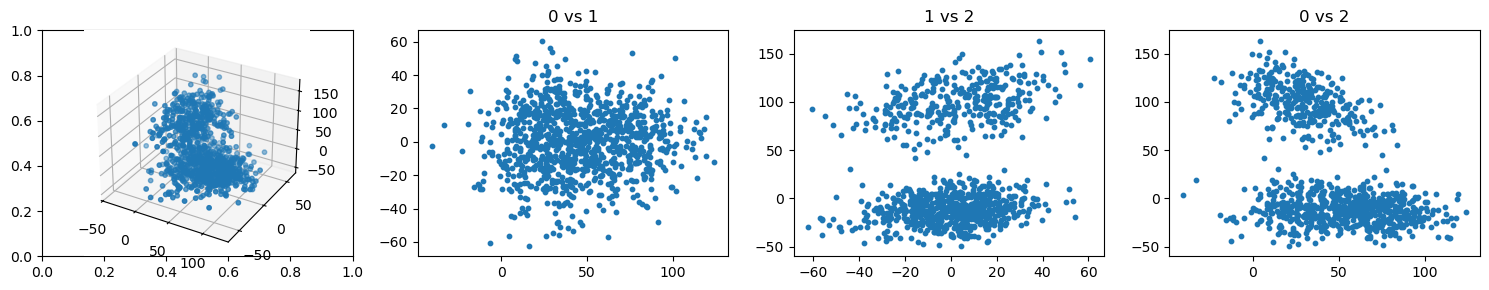

In [13]:
dataset_type = 'ellipsoid_homoskedastic_blobs'
n_samples = 1000
# n_features = 3

for n_features in [3,10]:

    for n_centers in [3]:
        for cluster_std in [1.0,2.0]:

            dataset_subtype = f'N{n_samples}_P{n_features}/k{n_centers}_std{cluster_std}'

            for sample_num,seed in enumerate(random_seeds_lst):

                X,y,transforms = make_heteroskedastic_anisotropic_blobs_nd(n_samples=n_samples,n_features=n_features,
                                                                                random_state=seed,cluster_std=cluster_std,
                                                                                centers=n_centers)

                extra_meta_info = {'cluster_std' : cluster_std}
                extra_param_info = {'transforms' : transforms,'cluster_label':y}

                save_dataset(X, dataset_type, n_samples, n_features, sample_num,
                            seed,dataset_sub_type=dataset_subtype,
                            extra_meta_info=extra_meta_info,
                            extra_param_info=extra_param_info)

                if sample_num == 0:
                    plot_3d_scatters(X,'',y=None)


In [14]:
# ellips_homosk_clusters = make_heteroskedastic_anisotropic_blobs_nd(cluster_std=[1.0,1.0,1.0])
# plot_3d_scatters(ellips_homosk_clusters[0],'')

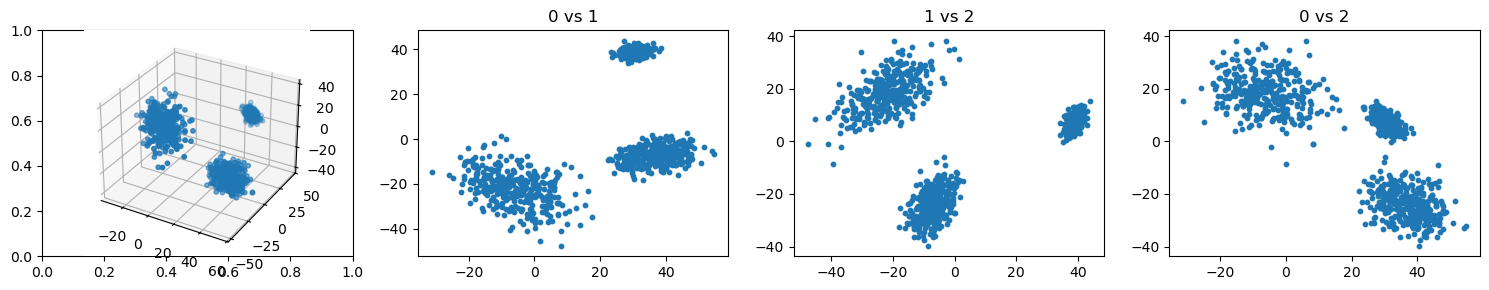

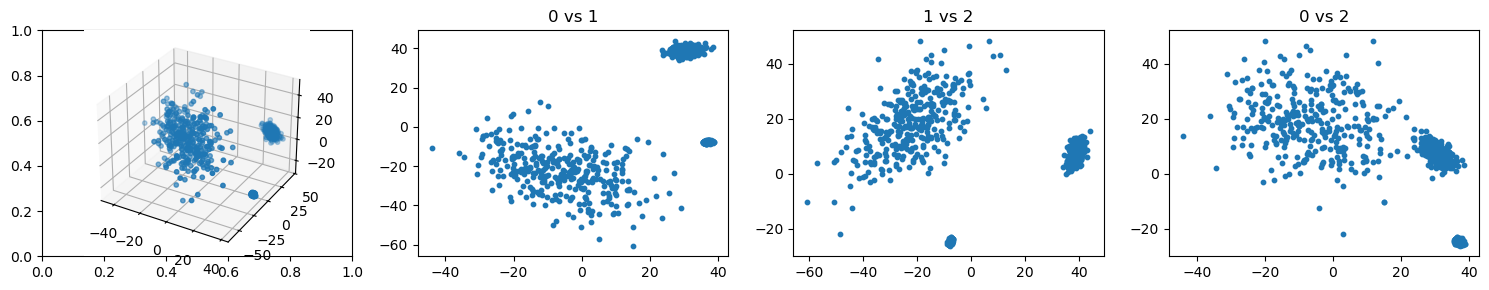

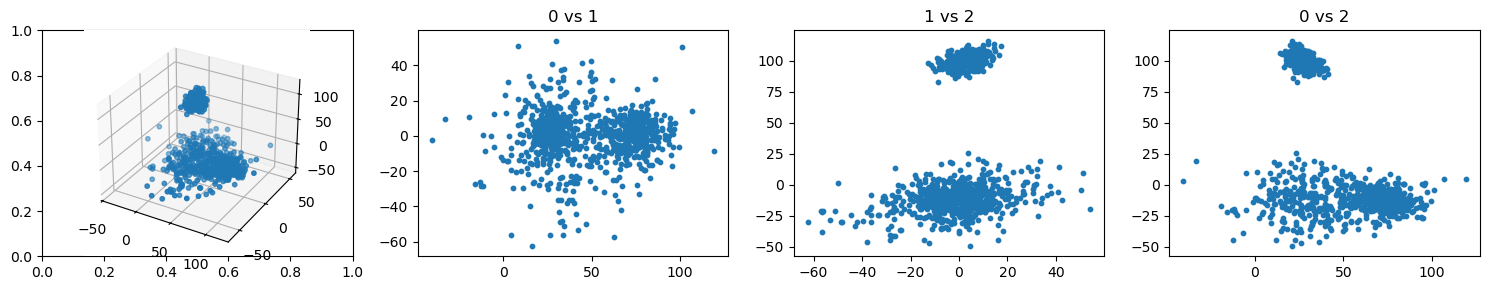

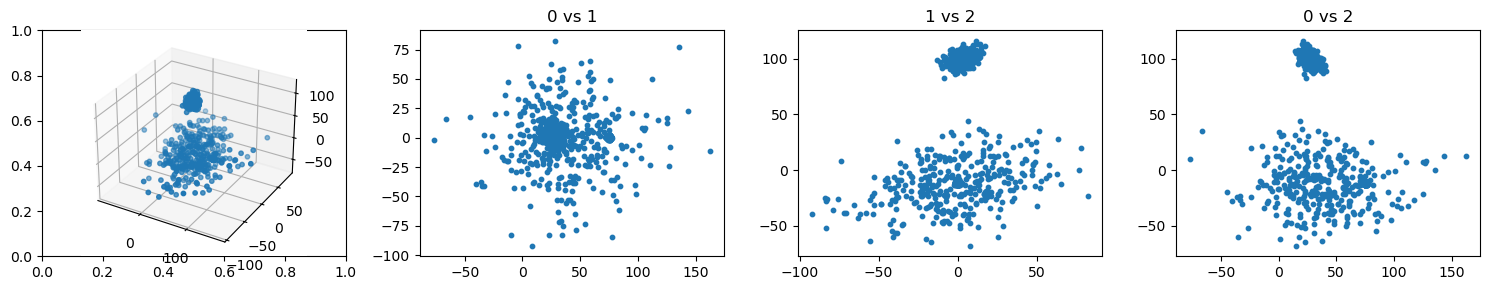

In [15]:
dataset_type = 'ellipsoid_heteroskedastic_blobs'
n_samples = 1000
n_features = 3

cluster_vecs_dict = {'_v0' : [1.0,2.0,0.5], '_v1' : [0.1,3.0,0.5]}

for n_features in [3,10]:

    for n_centers in [3]:

        for cluster_std_key in cluster_vecs_dict.keys():

            cluster_std = cluster_vecs_dict[cluster_std_key]
            
            dataset_subtype = f'N{n_samples}_P{n_features}/k{n_centers}_std{cluster_std_key}'

            for sample_num,seed in enumerate(random_seeds_lst):

                X,y,transforms = make_heteroskedastic_anisotropic_blobs_nd(n_samples=n_samples,n_features=n_features,
                                                                                random_state=seed,cluster_std=cluster_std,
                                                                                centers=n_centers)

                extra_param_info = {'transforms' : transforms,'cluster_label':y,'cluster_std' : cluster_std}

                save_dataset(X, dataset_type, n_samples, n_features, sample_num,
                            seed,dataset_sub_type=dataset_subtype,
                            extra_meta_info=extra_meta_info,
                            extra_param_info=extra_param_info)

                if sample_num == 0:
                    plot_3d_scatters(X,'',y=None)


## save isotropic gaussian blob

In [16]:
def isotropic_gaussian(n_samples, n_features,random_state=None):
    mean = np.zeros(n_features)
    cov = np.zeros(shape=(n_features,n_features))
    np.fill_diagonal(cov, 1)

    rng = np.random.default_rng(seed=random_state)

    return rng.multivariate_normal(mean, cov,size=n_samples)

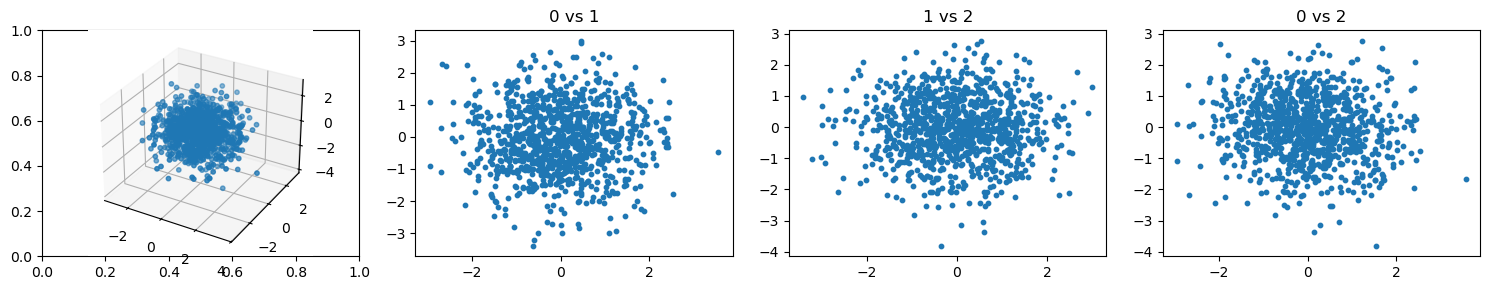

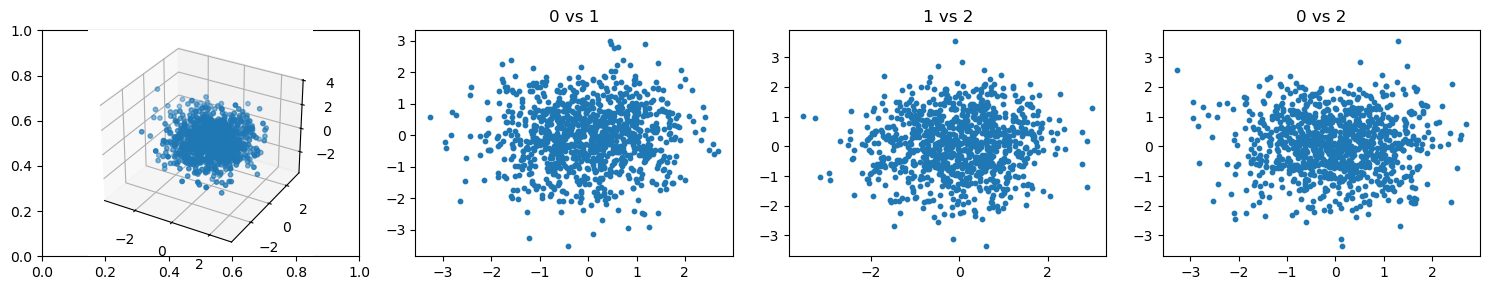

In [17]:
dataset_type = 'isotropic_gaussian_cloud'
n_samples = 1000

dataset_subtype = f'N{n_samples}_P{n_features}/'

for n_features in [3,10]:

    for sample_num,seed in enumerate(random_seeds_lst):
        
        X = isotropic_gaussian(n_samples,n_features,seed)
        save_dataset(X, dataset_type, n_samples, n_features, sample_num, seed,dataset_sub_type=dataset_subtype)

        if sample_num == 0:
            plot_3d_scatters(X,'',y=None)


## save anisotropic gaussian blob

In [18]:
def random_covariance_gaussian(n_samples, n_features,cov,random_state=None):

    mean = np.zeros(n_features)
    # cov = np.zeros(shape=(n_features,n_features))
    # np.fill_diagonal(cov, 1)

    rng = np.random.default_rng(seed=random_state)

    return rng.multivariate_normal(mean, cov,size=n_samples)

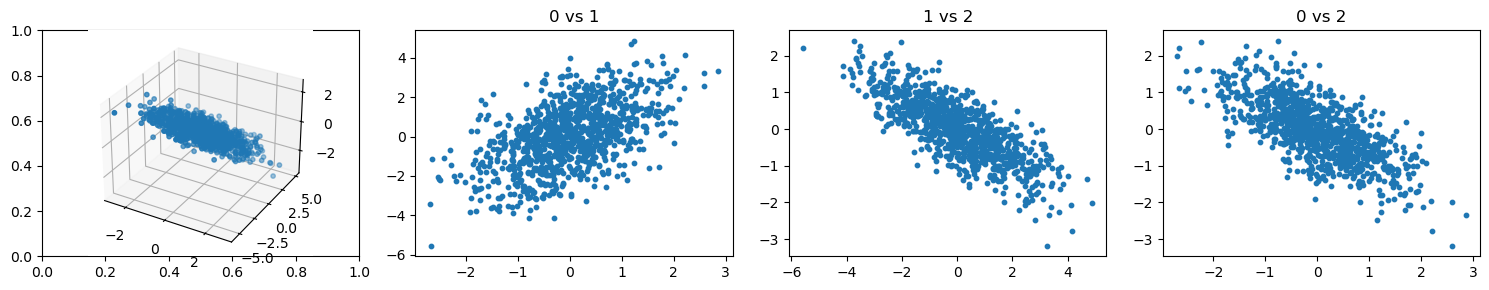

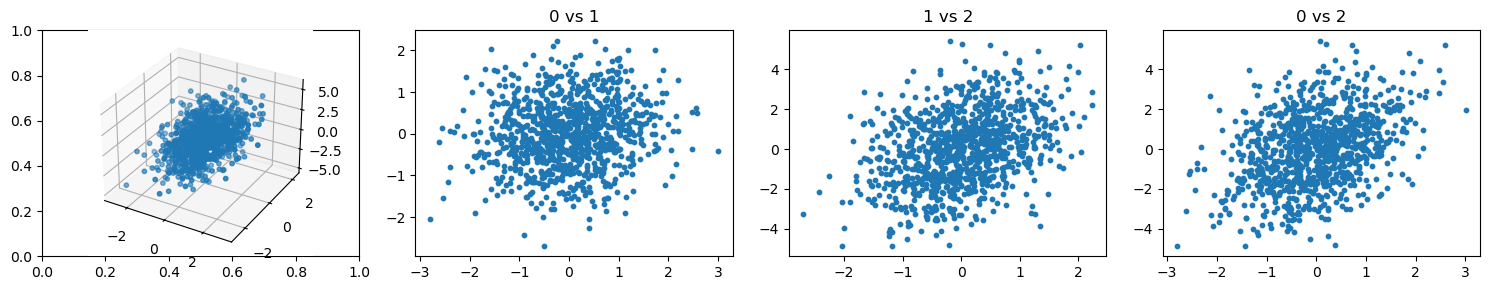

In [19]:
dataset_type = 'randomCov_gaussian_cloud'
n_samples = 1000
# n_features = 3

for n_features in [3,10]:

    dataset_subtype = f'N{n_samples}_P{n_features}/'

    for sample_num,seed in enumerate(random_seeds_lst):
        
        cov = datasets.make_spd_matrix(n_dim=n_features, random_state=seed)
        X = random_covariance_gaussian(n_samples,n_features,cov,seed)

        extra_param_info = {'cov' : cov}

        save_dataset(X, dataset_type, n_samples, n_features, sample_num, seed,
                    dataset_sub_type=dataset_subtype,
                    extra_param_info=extra_param_info)

        if sample_num == 0:
            plot_3d_scatters(X,'',y=None)


## generate noisy concentric spheres

In [20]:
def noisy_concentric_spheres(n_samples=1000,n_spheres=4,noise=0.2, center=(0, 0, 0),random_state=None, radii_arr=None):
    
    if radii_arr is None:
        scale_factor = 1
        min_r = 1*scale_factor
        radii_arr = np.linspace(min_r, n_spheres*scale_factor,n_spheres)

    if isinstance(noise, float):
        # num_center = 1
        pass
    elif isinstance(noise, list):
        assert n_spheres == len(noise)
    else:
        # raise error
        return

    # print(len(radii_arr))
    assert len(radii_arr) == n_spheres

    n_samples_per_shell = int(n_samples / n_spheres)
    rng = np.random.default_rng(seed=random_state)
    if isinstance(noise, float):
        # num_center = 1
        pass
    elif isinstance(noise, list):
        assert n_spheres == len(noise)
    else:
        # raise error
        return

    X_list = []

    for i, r in enumerate(radii_arr):
        
        if isinstance(noise,float):
            noise_r = noise
        else:
            noise_r = noise[i]

        # sample spherical coords
        theta = rng.uniform(0, 2 * np.pi, n_samples_per_shell)
        phi = np.arccos(rng.uniform(-1, 1, n_samples_per_shell))
                
        r_noisy_x = r + rng.normal(0, noise_r, n_samples_per_shell)
        r_noisy_y = r + rng.normal(0, noise_r, n_samples_per_shell)
        r_noisy_z = r + rng.normal(0, noise_r, n_samples_per_shell)

        # convert to feature vector
        x = r_noisy_x * np.sin(phi) * np.cos(theta)
        y = r_noisy_y * np.sin(phi) * np.sin(theta)
        z = r_noisy_z * np.cos(phi)
        
        shell_points = np.stack([x, y, z], axis=1)
        X_list.append(shell_points)
    
    X = np.vstack(X_list)


    return X

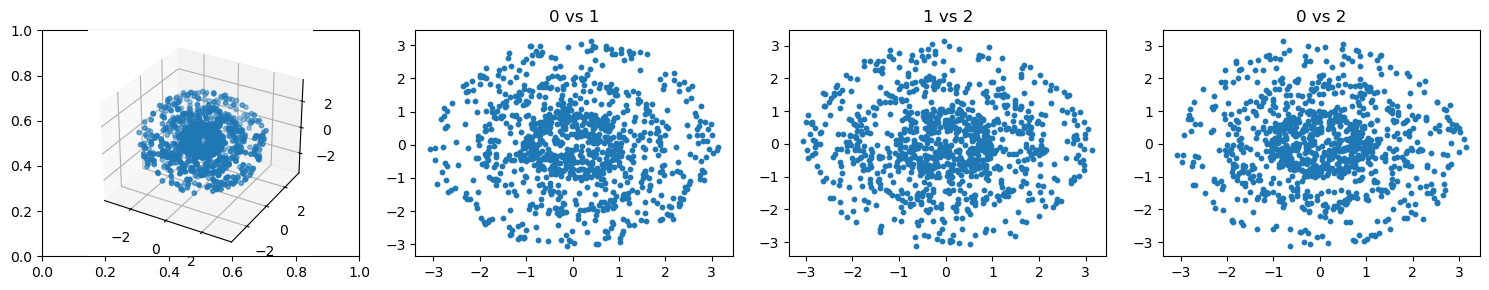

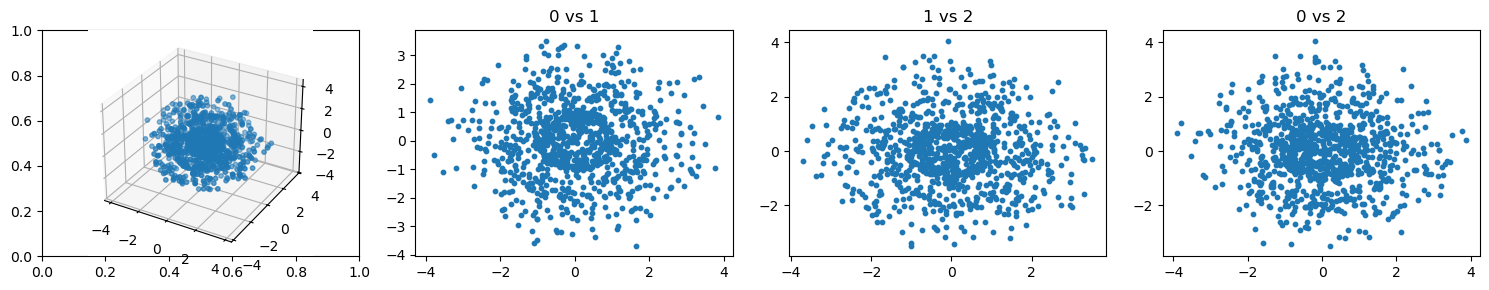

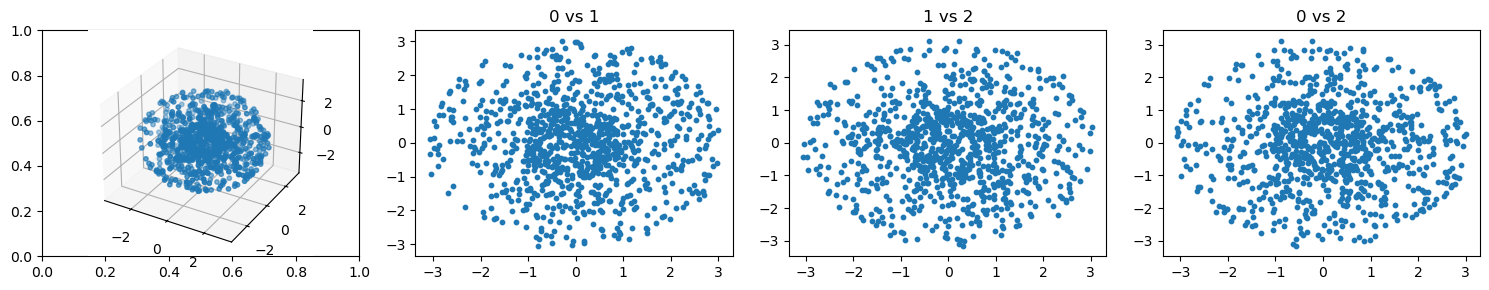

In [21]:
dataset_type = 'noisy_concentric_spheres'
n_samples = 1000
n_features = 3
n_spheres = 3

noise_ver_vec_dict = {'v0' : [0.1,0.1,0.1], 'v1' : [0.1,0.2,0.5], 'v2' : [0.2,0.3,0.1]}

for noise_ver in noise_ver_vec_dict.keys():

    noise_vec = noise_ver_vec_dict[noise_ver]

    dataset_subtype = f'N{n_samples}_P{n_features}/noise_{noise_ver}'

    for sample_num,seed in enumerate(random_seeds_lst):

        X = noisy_concentric_spheres(n_samples=n_samples,n_spheres=n_spheres,noise=noise_vec)

        extra_meta_info = {'n_spheres' : n_spheres}
        extra_param_info = {'noise' : noise_vec}

        save_dataset(X, dataset_type, n_samples, n_features, sample_num, seed,
                     extra_param_info=extra_param_info,
                     dataset_sub_type=dataset_subtype,
                     extra_meta_info = extra_meta_info)

        if sample_num == 0:
            plot_3d_scatters(X,'',y=None)
